In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, ops
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from tqdm import tqdm


In [6]:
BATCH_SIZE = 32
NUM_OF_WORKERS = 2
NUM_OF_EPOCHS = 40

trainset = datasets.FashionMNIST('data_original/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
testset = datasets.FashionMNIST('data_original/', download=True, train=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

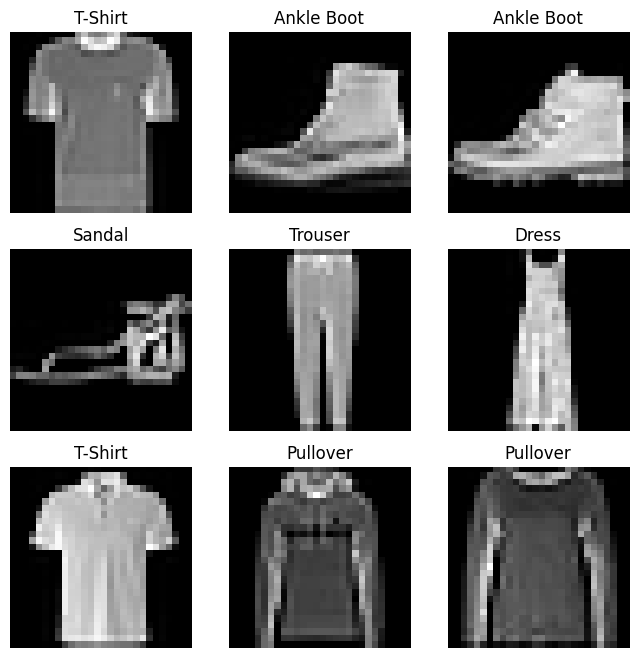

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [20]:
model.to(device)

GarmentClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
import pickle

batch_tr_loss = {}
batch_te_loss = {}

best_test_loss = float('inf')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# epoch loss and accuracy
tr_loss, tr_acc = [], []
te_loss, te_acc = [], []

for t in (range(NUM_OF_EPOCHS)):
    model.train()
    batch_loss, batch_accuracy = [], []
    print(f"Epoch {t+1} Training...")
    for X,y in tqdm(trainloader):
        X = X.to(device)
        y = y.to(device)
        predicted = model(X)
        loss = loss_fn(predicted, y)
        batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
        batch_loss.append(float(loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    batches = len(batch_loss)
    tr_loss.append(sum(batch_loss)/batches)
    tr_acc.append(sum(batch_accuracy)/batches)

    model.eval()
    with torch.no_grad():
        batch_loss, batch_accuracy = [], []
        print(f"Epoch {t+1} Testing...")
        for X,y in tqdm(testloader):
            X = X.to(device)
            y = y.to(device)
            predicted = model(X)
            loss = loss_fn(predicted, y)
            batch_accuracy.append(float(torch.argmax(predicted, dim=1).eq(y).sum().item()/len(y)))
            batch_loss.append(float(loss.item()))

        batches = len(batch_loss)
        te_loss.append(sum(batch_loss)/batches)
        te_acc.append(sum(batch_accuracy)/batches)

    # Save the model's weights after each epoch
    torch.save(model.state_dict(), f"model_weights/{BATCH_SIZE}_model_weights.pth")

    # Check if the current test loss is the best so far
    if te_loss[-1] < best_test_loss:
        best_test_loss = te_loss[-1]
        # Save the model's weights with the best test loss
        torch.save(model.state_dict(), f"model_weights/{BATCH_SIZE}_best_model_weights.pth")

    print(f"Epoch {t+1}: Train_accuracy: {(100*tr_acc[-1]):>0.2f}%, Train_loss: {tr_loss[-1]:>8f}, Test_accuracy: {(100*te_acc[-1]):>0.2f}%, Test_loss: {te_loss[-1]:>8f}")


Epoch 1 Training...


100%|██████████| 1875/1875 [00:12<00:00, 154.25it/s]


Epoch 1 Testing...


100%|██████████| 313/313 [00:04<00:00, 72.84it/s] 


Epoch 1: Train_accuracy: 75.08%, Train_loss: 0.650599, Test_accuracy: 82.06%, Test_loss: 0.486519
Epoch 2 Training...


100%|██████████| 1875/1875 [00:11<00:00, 165.58it/s]


Epoch 2 Testing...


100%|██████████| 313/313 [00:04<00:00, 73.50it/s] 


Epoch 2: Train_accuracy: 84.46%, Train_loss: 0.423421, Test_accuracy: 85.80%, Test_loss: 0.391296
Epoch 3 Training...


100%|██████████| 1875/1875 [00:11<00:00, 168.59it/s]


Epoch 3 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.02it/s] 


Epoch 3: Train_accuracy: 86.89%, Train_loss: 0.355345, Test_accuracy: 86.95%, Test_loss: 0.362313
Epoch 4 Training...


100%|██████████| 1875/1875 [00:11<00:00, 170.45it/s]


Epoch 4 Testing...


100%|██████████| 313/313 [00:04<00:00, 74.41it/s] 


Epoch 4: Train_accuracy: 88.09%, Train_loss: 0.320786, Test_accuracy: 87.61%, Test_loss: 0.331995
Epoch 5 Training...


100%|██████████| 1875/1875 [00:11<00:00, 164.45it/s]


Epoch 5 Testing...


100%|██████████| 313/313 [00:04<00:00, 72.89it/s] 


Epoch 5: Train_accuracy: 88.95%, Train_loss: 0.297493, Test_accuracy: 87.88%, Test_loss: 0.329989
Epoch 6 Training...


100%|██████████| 1875/1875 [00:11<00:00, 168.09it/s]


Epoch 6 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.69it/s] 


Epoch 6: Train_accuracy: 89.55%, Train_loss: 0.278318, Test_accuracy: 88.86%, Test_loss: 0.305342
Epoch 7 Training...


100%|██████████| 1875/1875 [00:10<00:00, 179.37it/s]


Epoch 7 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.85it/s] 


Epoch 7: Train_accuracy: 90.09%, Train_loss: 0.263638, Test_accuracy: 88.63%, Test_loss: 0.307216
Epoch 8 Training...


100%|██████████| 1875/1875 [00:11<00:00, 169.64it/s]


Epoch 8 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.41it/s] 


Epoch 8: Train_accuracy: 90.53%, Train_loss: 0.251436, Test_accuracy: 89.55%, Test_loss: 0.289557
Epoch 9 Training...


100%|██████████| 1875/1875 [00:11<00:00, 159.64it/s]


Epoch 9 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.07it/s] 


Epoch 9: Train_accuracy: 90.94%, Train_loss: 0.239293, Test_accuracy: 89.26%, Test_loss: 0.297578
Epoch 10 Training...


100%|██████████| 1875/1875 [00:11<00:00, 167.19it/s]


Epoch 10 Testing...


100%|██████████| 313/313 [00:04<00:00, 73.70it/s] 


Epoch 10: Train_accuracy: 91.36%, Train_loss: 0.228614, Test_accuracy: 89.71%, Test_loss: 0.288014
Epoch 11 Training...


100%|██████████| 1875/1875 [00:11<00:00, 160.48it/s]


Epoch 11 Testing...


100%|██████████| 313/313 [00:04<00:00, 73.41it/s] 


Epoch 11: Train_accuracy: 91.72%, Train_loss: 0.220008, Test_accuracy: 89.44%, Test_loss: 0.292474
Epoch 12 Training...


100%|██████████| 1875/1875 [00:11<00:00, 165.74it/s]


Epoch 12 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.09it/s] 


Epoch 12: Train_accuracy: 92.13%, Train_loss: 0.211941, Test_accuracy: 89.51%, Test_loss: 0.300751
Epoch 13 Training...


100%|██████████| 1875/1875 [00:11<00:00, 168.54it/s]


Epoch 13 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.68it/s] 


Epoch 13: Train_accuracy: 92.32%, Train_loss: 0.203754, Test_accuracy: 89.60%, Test_loss: 0.305209
Epoch 14 Training...


100%|██████████| 1875/1875 [00:11<00:00, 167.76it/s]


Epoch 14 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.66it/s] 


Epoch 14: Train_accuracy: 92.64%, Train_loss: 0.195302, Test_accuracy: 89.34%, Test_loss: 0.311699
Epoch 15 Training...


100%|██████████| 1875/1875 [00:11<00:00, 167.31it/s]


Epoch 15 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.24it/s] 


Epoch 15: Train_accuracy: 92.93%, Train_loss: 0.187593, Test_accuracy: 89.93%, Test_loss: 0.299491
Epoch 16 Training...


100%|██████████| 1875/1875 [00:11<00:00, 167.15it/s]


Epoch 16 Testing...


100%|██████████| 313/313 [00:04<00:00, 75.60it/s] 


Epoch 16: Train_accuracy: 93.14%, Train_loss: 0.181448, Test_accuracy: 89.84%, Test_loss: 0.307669
Epoch 17 Training...


100%|██████████| 1875/1875 [00:11<00:00, 162.39it/s]


Epoch 17 Testing...


100%|██████████| 313/313 [00:04<00:00, 70.45it/s] 


Epoch 17: Train_accuracy: 93.20%, Train_loss: 0.178141, Test_accuracy: 90.29%, Test_loss: 0.299567
Epoch 18 Training...


100%|██████████| 1875/1875 [00:11<00:00, 161.48it/s]


Epoch 18 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.22it/s] 


Epoch 18: Train_accuracy: 93.51%, Train_loss: 0.171964, Test_accuracy: 89.20%, Test_loss: 0.333698
Epoch 19 Training...


100%|██████████| 1875/1875 [00:10<00:00, 172.44it/s]


Epoch 19 Testing...


100%|██████████| 313/313 [00:04<00:00, 70.71it/s] 


Epoch 19: Train_accuracy: 93.58%, Train_loss: 0.166906, Test_accuracy: 89.84%, Test_loss: 0.301715
Epoch 20 Training...


100%|██████████| 1875/1875 [00:11<00:00, 164.61it/s]


Epoch 20 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.96it/s] 


Epoch 20: Train_accuracy: 93.80%, Train_loss: 0.161576, Test_accuracy: 90.22%, Test_loss: 0.301254
Epoch 21 Training...


100%|██████████| 1875/1875 [00:10<00:00, 174.25it/s]


Epoch 21 Testing...


100%|██████████| 313/313 [00:04<00:00, 73.47it/s] 


Epoch 21: Train_accuracy: 94.16%, Train_loss: 0.153032, Test_accuracy: 90.30%, Test_loss: 0.309617
Epoch 22 Training...


100%|██████████| 1875/1875 [00:11<00:00, 163.84it/s]


Epoch 22 Testing...


100%|██████████| 313/313 [00:04<00:00, 72.86it/s] 


Epoch 22: Train_accuracy: 94.18%, Train_loss: 0.150509, Test_accuracy: 90.00%, Test_loss: 0.321318
Epoch 23 Training...


100%|██████████| 1875/1875 [00:12<00:00, 152.44it/s]


Epoch 23 Testing...


100%|██████████| 313/313 [00:04<00:00, 70.17it/s] 


Epoch 23: Train_accuracy: 94.51%, Train_loss: 0.142743, Test_accuracy: 89.78%, Test_loss: 0.337293
Epoch 24 Training...


100%|██████████| 1875/1875 [00:10<00:00, 180.96it/s]


Epoch 24 Testing...


100%|██████████| 313/313 [00:04<00:00, 73.98it/s] 


Epoch 24: Train_accuracy: 94.65%, Train_loss: 0.140366, Test_accuracy: 89.97%, Test_loss: 0.339036
Epoch 25 Training...


100%|██████████| 1875/1875 [00:09<00:00, 193.90it/s]


Epoch 25 Testing...


100%|██████████| 313/313 [00:04<00:00, 76.18it/s] 


Epoch 25: Train_accuracy: 94.76%, Train_loss: 0.136405, Test_accuracy: 89.75%, Test_loss: 0.349510
Epoch 26 Training...


100%|██████████| 1875/1875 [00:09<00:00, 196.23it/s]


Epoch 26 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.07it/s] 


Epoch 26: Train_accuracy: 95.01%, Train_loss: 0.132355, Test_accuracy: 90.12%, Test_loss: 0.364129
Epoch 27 Training...


100%|██████████| 1875/1875 [00:09<00:00, 202.91it/s]


Epoch 27 Testing...


100%|██████████| 313/313 [00:04<00:00, 74.92it/s] 


Epoch 27: Train_accuracy: 95.01%, Train_loss: 0.129602, Test_accuracy: 89.46%, Test_loss: 0.369712
Epoch 28 Training...


100%|██████████| 1875/1875 [00:10<00:00, 176.69it/s]


Epoch 28 Testing...


100%|██████████| 313/313 [00:03<00:00, 79.12it/s] 


Epoch 28: Train_accuracy: 95.08%, Train_loss: 0.129025, Test_accuracy: 90.04%, Test_loss: 0.369040
Epoch 29 Training...


100%|██████████| 1875/1875 [00:09<00:00, 194.19it/s]


Epoch 29 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.54it/s] 


Epoch 29: Train_accuracy: 95.38%, Train_loss: 0.119973, Test_accuracy: 89.84%, Test_loss: 0.382604
Epoch 30 Training...


100%|██████████| 1875/1875 [00:09<00:00, 195.33it/s]


Epoch 30 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.77it/s] 


Epoch 30: Train_accuracy: 95.41%, Train_loss: 0.120484, Test_accuracy: 89.53%, Test_loss: 0.400121
Epoch 31 Training...


100%|██████████| 1875/1875 [00:09<00:00, 190.04it/s]


Epoch 31 Testing...


100%|██████████| 313/313 [00:04<00:00, 63.44it/s] 


Epoch 31: Train_accuracy: 95.49%, Train_loss: 0.117120, Test_accuracy: 89.50%, Test_loss: 0.407328
Epoch 32 Training...


100%|██████████| 1875/1875 [00:11<00:00, 169.55it/s]


Epoch 32 Testing...


100%|██████████| 313/313 [00:04<00:00, 74.48it/s] 


Epoch 32: Train_accuracy: 95.64%, Train_loss: 0.113137, Test_accuracy: 89.62%, Test_loss: 0.412572
Epoch 33 Training...


100%|██████████| 1875/1875 [00:12<00:00, 153.43it/s]


Epoch 33 Testing...


100%|██████████| 313/313 [00:04<00:00, 67.89it/s] 


Epoch 33: Train_accuracy: 95.85%, Train_loss: 0.108854, Test_accuracy: 89.53%, Test_loss: 0.425930
Epoch 34 Training...


100%|██████████| 1875/1875 [00:09<00:00, 197.47it/s]


Epoch 34 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.50it/s] 


Epoch 34: Train_accuracy: 95.89%, Train_loss: 0.107683, Test_accuracy: 89.74%, Test_loss: 0.413746
Epoch 35 Training...


100%|██████████| 1875/1875 [00:09<00:00, 198.07it/s]


Epoch 35 Testing...


100%|██████████| 313/313 [00:04<00:00, 77.74it/s] 


Epoch 35: Train_accuracy: 96.06%, Train_loss: 0.103327, Test_accuracy: 89.60%, Test_loss: 0.445846
Epoch 36 Training...


100%|██████████| 1875/1875 [00:10<00:00, 173.18it/s]


Epoch 36 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.60it/s] 


Epoch 36: Train_accuracy: 95.99%, Train_loss: 0.103489, Test_accuracy: 89.89%, Test_loss: 0.443415
Epoch 37 Training...


100%|██████████| 1875/1875 [00:10<00:00, 178.12it/s]


Epoch 37 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.82it/s] 


Epoch 37: Train_accuracy: 96.16%, Train_loss: 0.099378, Test_accuracy: 89.53%, Test_loss: 0.455238
Epoch 38 Training...


100%|██████████| 1875/1875 [00:10<00:00, 177.69it/s]


Epoch 38 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.55it/s] 


Epoch 38: Train_accuracy: 96.25%, Train_loss: 0.097175, Test_accuracy: 89.54%, Test_loss: 0.466960
Epoch 39 Training...


100%|██████████| 1875/1875 [00:10<00:00, 177.33it/s]


Epoch 39 Testing...


100%|██████████| 313/313 [00:04<00:00, 78.23it/s] 


Epoch 39: Train_accuracy: 96.18%, Train_loss: 0.097397, Test_accuracy: 89.50%, Test_loss: 0.474445
Epoch 40 Training...


100%|██████████| 1875/1875 [00:10<00:00, 177.15it/s]


Epoch 40 Testing...


100%|██████████| 313/313 [00:03<00:00, 78.81it/s] 

Epoch 40: Train_accuracy: 96.32%, Train_loss: 0.093706, Test_accuracy: 89.59%, Test_loss: 0.508237


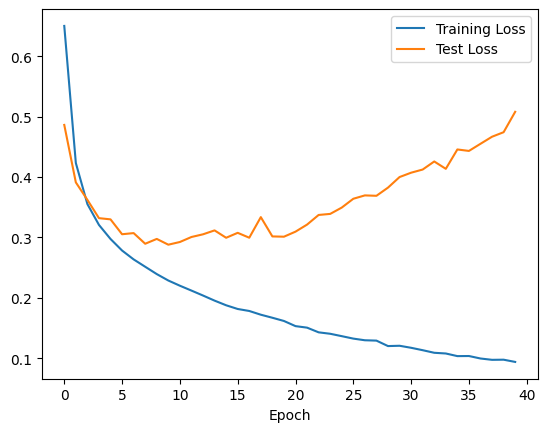

In [29]:
import matplotlib.pyplot as plt

# Plot the training loss and accuracy
plt.plot(tr_loss, label="Training Loss")
plt.plot(te_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()


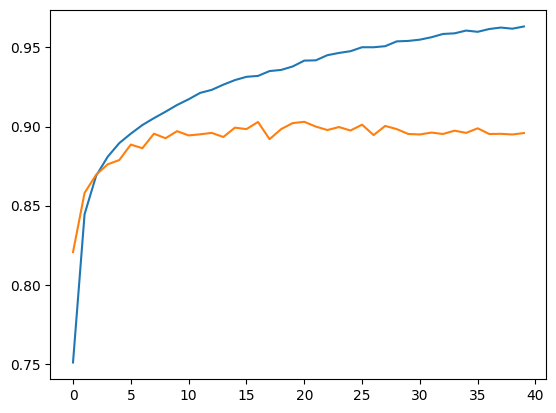

In [30]:

plt.plot(tr_acc, label="Training Accuracy")
plt.plot(te_acc, label="Test Accuracy")

In [26]:
torch.save(model.state_dict(), f"model_weights/simplecnn_model_weights.pth")